# Project Overview

- This project is centered on using Natural Language Processing (NLP) and machine learning to analyze social media data, specifically tweets, to distinguish between those that are related to natural disasters and those that are not. The objective is to preprocess the text in tweets, apply NLP techniques for analysis, and then use machine learning models to classify each tweet. The aim is to demonstrate how NLP and machine learning can be applied to real-world problems, such as enhancing disaster response mechanisms through the analysis of social media.

# Import the essential packages

In [32]:
import numpy as np
import pandas as pd
import nltk
import nltk.corpus
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader.wordnet import VERB, NOUN, ADJ, ADV
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
import random
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.svm import SVC
import seaborn as sns

# <center>**1. Load and Explore the dataset**</center>

In [35]:
tweets_data = pd.read_csv('train.csv')

In [37]:
tweets_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [39]:
tweets_data.shape

(7613, 5)

In [41]:
tweets_data.duplicated(subset='id').sum()

0

In [43]:
tweets_data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [45]:
tweets_data['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [47]:
tweets_data['len_raw_text'] = tweets_data['text'].apply(lambda x : len(x))
tweets_data[['len_raw_text']].describe().T

,count,mean,std,min,25%,50%,75%,max
len_raw_text,7613.0,101.037436,33.781325,7.0,78.0,107.0,133.0,157.0


- This dataset consists of 7613 tweets with 5 columns.
- There are no duplicates in this dataset.
- **Columns descriptions**
    - id - a unique identifier for each tweet.
    - text - the text of the tweet
    - location - the location the tweet was sent from (has 2533 missing values)
    - keyword - a particular keyword from the tweet (has 61 missing values)
    - target - this denotes whether a tweet is about a real disaster (1) or not (0)
- The tweets_traing dataset is divided in consideration of target variable into 3271 tweets with real disaster and 4342 tweets with no disaster.
- Prior to data preprocessing, the mean, median, standard deviation, minimum, and maximum values are 101, 107, 33.78, 7, and 157, respectively.

# <center>**2. Data Preprocessing**</center>

### **2.1  Clean the tweet text by removing noise such as special characters, URLs, and HTML tags.**

In [52]:
def cleaning(text):
    URLs = r'https?://\S+|www\.\S+'    
    html_tags = r'<.*?>'    
    special_characters = r'[^a-zA-Z\s]'
    new_line = r'(?:\s*\n\s*)|(?:\s+)'
    text = re.sub(URLs ,'', text)
    text = re.sub(html_tags ,'', text)
    text = re.sub(special_characters ,'', text)
    text = re.sub(new_line ,' ', text.strip())
    return text

**Apply cleaning function to text column in the tweets_data**

In [62]:
tweets_data['cleaned_text'] = tweets_data['text'].apply(cleaning)
tweets_data['len_cleaned_text'] = tweets_data['cleaned_text'].apply(lambda x : len(x))
tweets_data.head()

,id,keyword,location,text,target,len_raw_text,cleaned_text,len_cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,Our Deeds are the Reason of this earthquake Ma...,68
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada,37
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,All residents asked to shelter in place are be...,130
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfires evacuation orders in ...,56
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,Just got sent this photo from Ruby Alaska as s...,85


### 2.2 **Tokenization and Normalize the tweets by converting them to lowercase**

In [66]:
X = tweets_data['cleaned_text'].values 
X.shape 

(7613,)

In [68]:
X = [word_tokenize(tweet.lower()) for tweet in X]

In [70]:
print('First five tweets after tokenization: ')
print('_____________________________________')
print(X[:5])

First five tweets after tokenization: 
_____________________________________
[['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all'], ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'], ['all', 'residents', 'asked', 'to', 'shelter', 'in', 'place', 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected'], ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'in', 'california'], ['just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', 'alaska', 'as', 'smoke', 'from', 'wildfires', 'pours', 'into', 'a', 'school']]


### 2.3 **Spell-checking and correction, Removing stopwords, and applying Lemmatization.**

#### 2.3.1 **Spell-checking and correction**

**Take random sample of tweets list to campare between  vecorized and non vecorized SpellChecker_correction, which could work faster.**

In [98]:
random_sample = random.sample(X, 10)

In [100]:
print(random_sample)

[['krefeld', 'the', 'incident', 'happened', 'in', 'a', 'chemical', 'industry', 'park', 'emergency', 'operations', 'underway', 'a', 'building', 'reportly', 'collapsed', 'cnnbrk', 'ntvde'], ['womans', 'gps', 'app', 'guides', 'rescuers', 'to', 'injured', 'biker', 'in', 'marin', 'county', 'sfgate'], ['love', 'how', 'i', 'dont', 'get', 'in', 'any', 'trouble', 'for', 'having', 'people', 'over', 'and', 'the', 'house', 'still', 'being', 'trashed'], ['hermancranston', 'wired', 'reddit', 'will', 'now', 'quarantine', 'offensive', 'content'], ['kyrikoni', 'expressandstar', 'who', 'said', 'veg', 'and', 'fruit', 'was', 'good', 'for', 'you', 'hope', 'theres', 'been', 'no', 'injuries', 'or', 'fatalities'], ['on', 'anniversary', 'of', 'hiroshima', 'bombing', 'illustrated', 'timeline', 'of', 'bombings', 'eyewitness', 'account', 'particularly', 'horrifying'], ['photo', 'mothernaturenetwork', 'what', 'is', 'thundersnow', 'hearing', 'thunder', 'during', 'a', 'snowstorm', 'is', 'extremely', 'uncommon'], ['u

In [102]:
vecorized_spelling = np.vectorize(SpellChecker().correction)
non_vecorized_spelling = SpellChecker().correction

In [104]:
%%timeit
random_sample_1 = []
for tweet in random_sample:
    for i, word in enumerate(tweet):
        if corrected:=non_vecorized_spelling(word):
            tweet[i]= corrected
        else:
            tweet[i]='None'
    random_sample_1.append(tweet)

310 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [105]:
%%timeit
random_sample_2 = []
for tweet in random_sample:
    tweet = np.array(tweet)
    random_sample_2.append(list(vecorized_spelling(tweet)))

437 µs ± 2.06 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**Conclusion**
- Vectorized SpellChecker_correction function take more time than non_vectorized.

In [108]:
well_spelled_X = [] 
X_copy = X.copy()
for tweet in X_copy:
    for i, word in enumerate(tweet):
        if corrected:=non_vecorized_spelling(word):
            tweet[i]= corrected
        else:
            tweet[i]='None'
    well_spelled_X.append(tweet)

### 2.3.2 **Removing stopwords**

In [118]:
for i in range(len(well_spelled_X)):
    well_spelled_X[i] = [word for word in well_spelled_X[i] if word not in stopwords.words('english')]

### 2.3.3 **Applying Lemmatization.**

ـ WordNetLemmatizer.lemma() takes in an argument pos to understand the POS tag of the word/token because word-forms could be same but contextually or semantically different.

In [122]:
pos_map = {'NN': NOUN,
    'VB':VERB,
    'JJ' : ADJ,
    'RB':ADV  
}

In [124]:
lemma = WordNetLemmatizer()

In [126]:
Final_X = []
for tweet in well_spelled_X:
    lemma_tweet=[]
    tag_tweet = nltk.pos_tag(tweet)
    for tag_word in tag_tweet:
        word = tag_word[0]
        if tag_word[1][:2] in pos_map.keys():
            word = lemma.lemmatize(word, pos=pos_map[tag_word[1][:2]])
        lemma_tweet.append(word)
    Final_X.append(lemma_tweet)

print(len(Final_X))

7613


**After completing the data preprocessing step, let’s explore the number of features (words) before and after preprocessing.**

In [185]:
features_after_cleaning = len(set([w  for tweet in Final_X for w in tweet]))

In [187]:
features_befor_cleaning = len(set([w  for tweet in [tweet.split() for tweet in tweets_data['text'].values] for w in tweet])) 

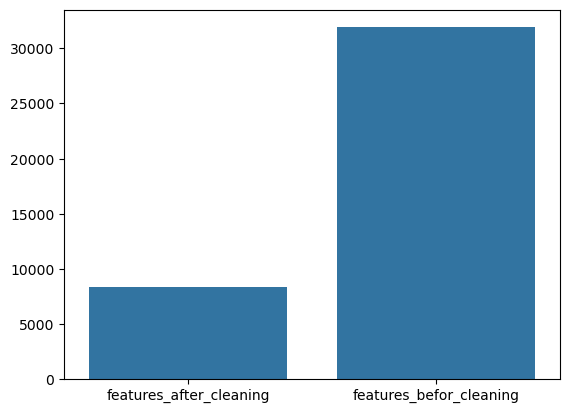

In [193]:
sns.barplot({'features_after_cleaning' : features_after_cleaning, 'features_befor_cleaning': features_befor_cleaning})
plt.show()

**Now that we’ve reached this point, we have completed the data preprocessing step.**

# <center>**3. Feature Extraction**</center>

### **We will employ TF-IDF for word embeddings and extract the tweets length**

1. Prepare data for word embedding and get the length of each tweet.

In [142]:
tweets_length = []
for tweet in Final_X:
    tweets_length.append(len(tweet))

len(tweets_length)

7613

In [153]:
cleaned_tweets = []
for tweet in Final_X:
    cleaned_tweets.append(' '.join(tweet))

In [155]:
len(cleaned_tweets)

7613

2. Instantiate the vectorizer and vectorize the tweets.

In [158]:
TfidfV = TfidfVectorizer()

In [160]:
matrix = TfidfV.fit_transform(cleaned_tweets).toarray()

In [162]:
columns = TfidfV.get_feature_names_out()

In [164]:
Vectorized_tweets = pd.DataFrame(matrix, columns=columns)

In [166]:
Vectorized_tweets['tweet_length'] = tweets_length

In [178]:
Vectorized_tweets['tweet_length'] = StandardScaler().fit_transform(Vectorized_tweets[['tweet_length']])

In [182]:
Vectorized_tweets.head()

,ab,aba,abandon,abbey,abbot,abhor,ability,abject,ablaze,able,...,zenith,zero,zimbabwe,zip,zipper,zodiac,zombie,zone,zoom,tweet_length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.513010
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.513010
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.664423
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.807368
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075707


# <center>**4. Model Training and Selection**</center>

### **1. Divide the dataset into training and testing sets for model evaluation and train Logistic Regression model.**
- **This is an example of splitting dataset into training and testing sets. However, for the remainder of the Capstone project, we will use cross-validation approach for both dataset splitting and model parameter optimization.**

In [199]:
X = Vectorized_tweets.values
y = tweets_data['target'].values

In [201]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5329, 8338), (2284, 8338), (5329,), (2284,))

In [202]:
model_lr = LogisticRegression()

In [205]:
model_lr.fit(x_train, y_train)
train_preds = model_lr.predict(x_train)
test_preds = model_lr.predict(x_test)

In [206]:
def cls_performance(y, y_pred):
    """ return dataframe and plot show the model performance
    """
    dict_ = {}
    dict_['accuracy_score'] = accuracy_score(y, y_pred)
    dict_['recall_score'] = recall_score(y, y_pred)
    dict_['precision_score'] = precision_score(y, y_pred)
    dict_['f1_score'] = f1_score(y, y_pred)
    dict_['con_matrix'] = ConfusionMatrixDisplay(confusion_matrix(y, y_pred))
    df = pd.DataFrame(dict_, index=[0])
    return df

In [209]:
train_metrices_l = cls_performance(y_train,train_preds)
train_metrices_l

,accuracy_score,recall_score,precision_score,f1_score,con_matrix
0,0.877651,0.77667,0.928942,0.846009,<sklearn.metrics._plot.confusion_matrix.Confus...


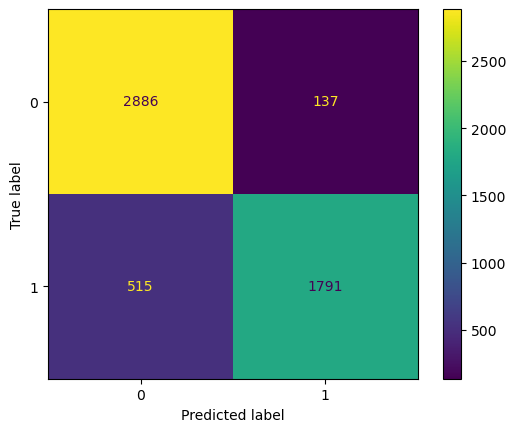

In [211]:
train_metrices_l.loc[0, 'con_matrix'].plot()
plt.show()

In [213]:
test_metrices_lr = cls_performance(y_test,test_preds)
test_metrices_lr

,accuracy_score,recall_score,precision_score,f1_score,con_matrix
0,0.798599,0.65285,0.834437,0.732558,<sklearn.metrics._plot.confusion_matrix.Confus...


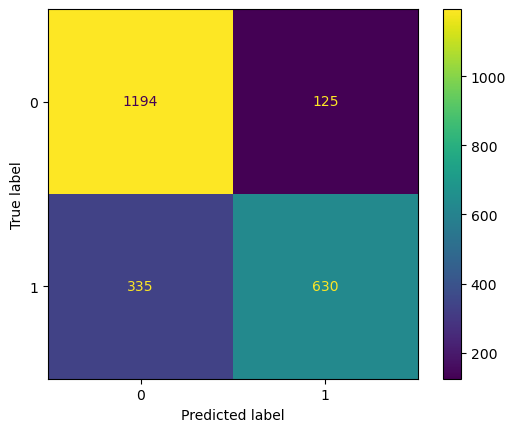

In [215]:
test_metrices_lr.loc[0, 'con_matrix'].plot()
plt.show()

**The model demonstrates poor performance on both the training and testing sets, as observed in the straightforward approach without applying any cross-validation techniques. Let’s now employ cross-validation for dataset splitting and model parameter optimization, and explore another models to determine the best option.**

### **2. Cross_Validation using Stratified K-Fold cross-validator**

**In this step, we will examine the accuracy metrics of Naive Bayes, Logistic Regression, Support Vector Machines, and neural networks models.**

**First, we’ll create two generic functions:**

- **KFold_CrossValid function**
    1.	It takes three arguments: X (an ndarray of shape (n_samples, n_features)), Y (an ndarray of shape (n_samples,)), estimator, and n_splits (a scalar with a default value of 5).
    2.	The function will train the specified estimator over the given number of splits.
    3.	The function returns a DataFrame that includes a confusion matrix plot and metrics that evaluate the estimator’s performance across all splits.
 
- **confusion_matrix_show function**

    1. This function to display all confusion matrix plots. In these plots, the first column represents the training set, the second column represents the testing set, and each row corresponds to one of the data splits.
    2. The dataframe returned from KFold_CrossValid function is the input of this function.

In [220]:
from sklearn.model_selection import StratifiedKFold

In [224]:
def KFold_CrossValid(X, Y, model, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits) #instantiation
    dict_ = {'train_acc_score':[], 'train_rec_score':[], 'train_prec_score':[], 'train_f1_score':[], 'train_con_matrix':[], 'test_acc_score':[],
    'test_rec_score':[], 'test_prec_score':[], 'test_f1_score':[], 'test_con_matrix':[]}
    for train_index, test_index in kf.split(X,Y):
        x_train = X[train_index]
        y_train = Y[train_index]
        x_test = X[test_index]
        y_test = y[test_index]
        model.fit(x_train, y_train)
        train_preds = model.predict(x_train)
        test_preds = model.predict(x_test)
        # first_split
        dict_['train_acc_score'].append(accuracy_score(y_train, train_preds))
        dict_['train_rec_score'].append(recall_score(y_train, train_preds))
        dict_['train_prec_score'].append(precision_score(y_train, train_preds))
        dict_['train_f1_score'].append(f1_score(y_train, train_preds))
        dict_['train_con_matrix'].append(ConfusionMatrixDisplay(confusion_matrix(y_train, train_preds)))        
        dict_['test_acc_score'].append(accuracy_score(y_test, test_preds))
        dict_['test_rec_score'].append(recall_score(y_test, test_preds))
        dict_['test_prec_score'].append(precision_score(y_test, test_preds))
        dict_['test_f1_score'].append(f1_score(y_test, test_preds))        
        dict_['test_con_matrix'].append(ConfusionMatrixDisplay(confusion_matrix(y_test, test_preds)))   

    df_index = [] # create index according to n_splits
    for i in range(1, n_splits+1):
        df_index.append(f'n_split_{i}')

    df = pd.DataFrame(dict_, index=df_index)
    for col in df.columns:
        if df[col].dtype=='float' or df[col].dtype=='int':
            df.loc['average', col] = df[col].mean()
    return df

In [401]:
def confusion_matrix_show(df):
    r = len(df.index)
    fig, axes = plt.subplots(nrows=r-1, ncols=2, figsize=(15,30))
    i = 0
    for index in df.index.difference(df.index[[-1]]):
        train_con_matrix = df.loc[index, 'train_con_matrix']
        train_con_matrix.plot(ax=axes[i,0])
        test_con_matrix = df.loc[index, 'test_con_matrix']
        test_con_matrix.plot(ax=axes[i,1])
        i+=1
    
    plt.show()

#### **2.1 Logistic Regression**

In [229]:
log_reg = LogisticRegression()
log_reg_metrices = KFold_CrossValid(X, y, log_reg, n_splits=5)

In [230]:
log_reg_metrices

,train_acc_score,train_rec_score,train_prec_score,train_f1_score,train_con_matrix,test_acc_score,test_rec_score,test_prec_score,test_f1_score,test_con_matrix
n_split_1,0.874548,0.763761,0.931903,0.839496,<sklearn.metrics._plot.confusion_matrix.Confus...,0.711753,0.436641,0.803371,0.565776,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_2,0.885550,0.794421,0.928954,0.856437,<sklearn.metrics._plot.confusion_matrix.Confus...,0.651346,0.441896,0.635165,0.521190,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_3,0.881117,0.776079,0.936376,0.848725,<sklearn.metrics._plot.confusion_matrix.Confus...,0.689429,0.538226,0.673040,0.598131,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_4,0.881300,0.784104,0.928507,0.850218,<sklearn.metrics._plot.confusion_matrix.Confus...,0.683968,0.408257,0.739612,0.526108,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_5,0.873912,0.769966,0.923888,0.839933,<sklearn.metrics._plot.confusion_matrix.Confus...,0.766754,0.622324,0.790291,0.696322,<sklearn.metrics._plot.confusion_matrix.Confus...
average,0.879286,0.777666,0.929926,0.846962,NaN,0.700650,0.489469,0.728296,0.581506,NaN


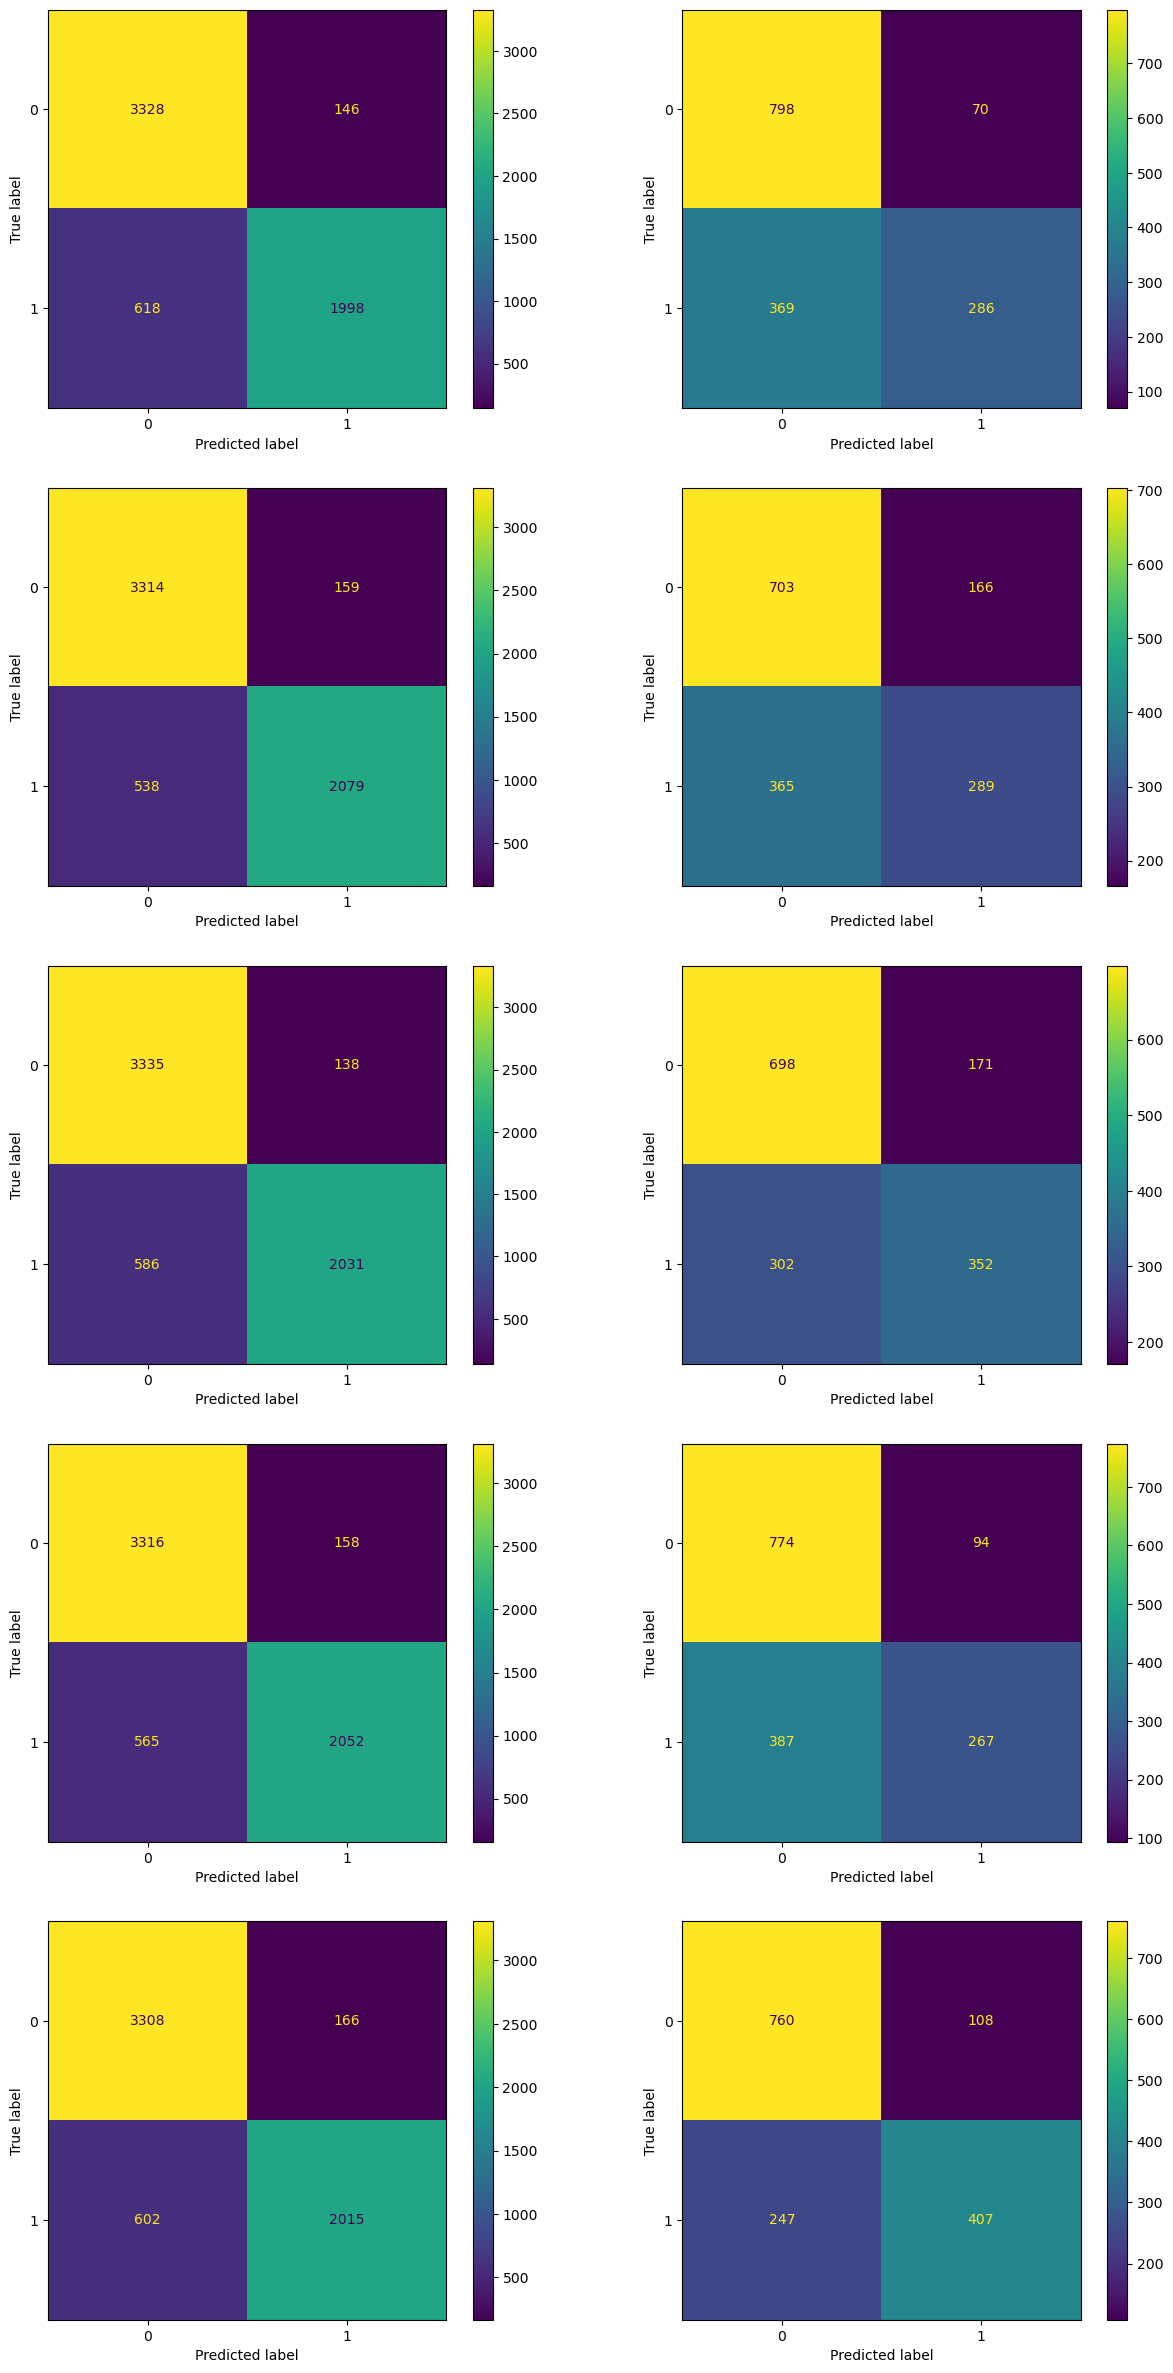

In [403]:
confusion_matrix_show(log_reg_metrices)

#### **2.2 Support Vector Machines model**

In [271]:
svc = SVC()
svc_metrices = KFold_CrossValid(X, y, svc, n_splits=5)

In [272]:
svc_metrices

,train_acc_score,train_rec_score,train_prec_score,train_f1_score,train_con_matrix,test_acc_score,test_rec_score,test_prec_score,test_f1_score,test_con_matrix
n_split_1,0.923153,0.836774,0.981614,0.903426,<sklearn.metrics._plot.confusion_matrix.Confus...,0.711097,0.386260,0.869416,0.534884,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_2,0.931856,0.862056,0.976623,0.915770,<sklearn.metrics._plot.confusion_matrix.Confus...,0.660538,0.382263,0.688705,0.491642,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_3,0.925944,0.844478,0.980479,0.907411,<sklearn.metrics._plot.confusion_matrix.Confus...,0.679580,0.434251,0.706468,0.537879,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_4,0.927926,0.852885,0.976378,0.910463,<sklearn.metrics._plot.confusion_matrix.Confus...,0.664258,0.336391,0.740741,0.462671,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_5,0.925464,0.848682,0.974550,0.907271,<sklearn.metrics._plot.confusion_matrix.Confus...,0.771353,0.570336,0.847727,0.681901,<sklearn.metrics._plot.confusion_matrix.Confus...
average,0.926869,0.848975,0.977929,0.908868,NaN,0.697365,0.421900,0.770611,0.541795,NaN


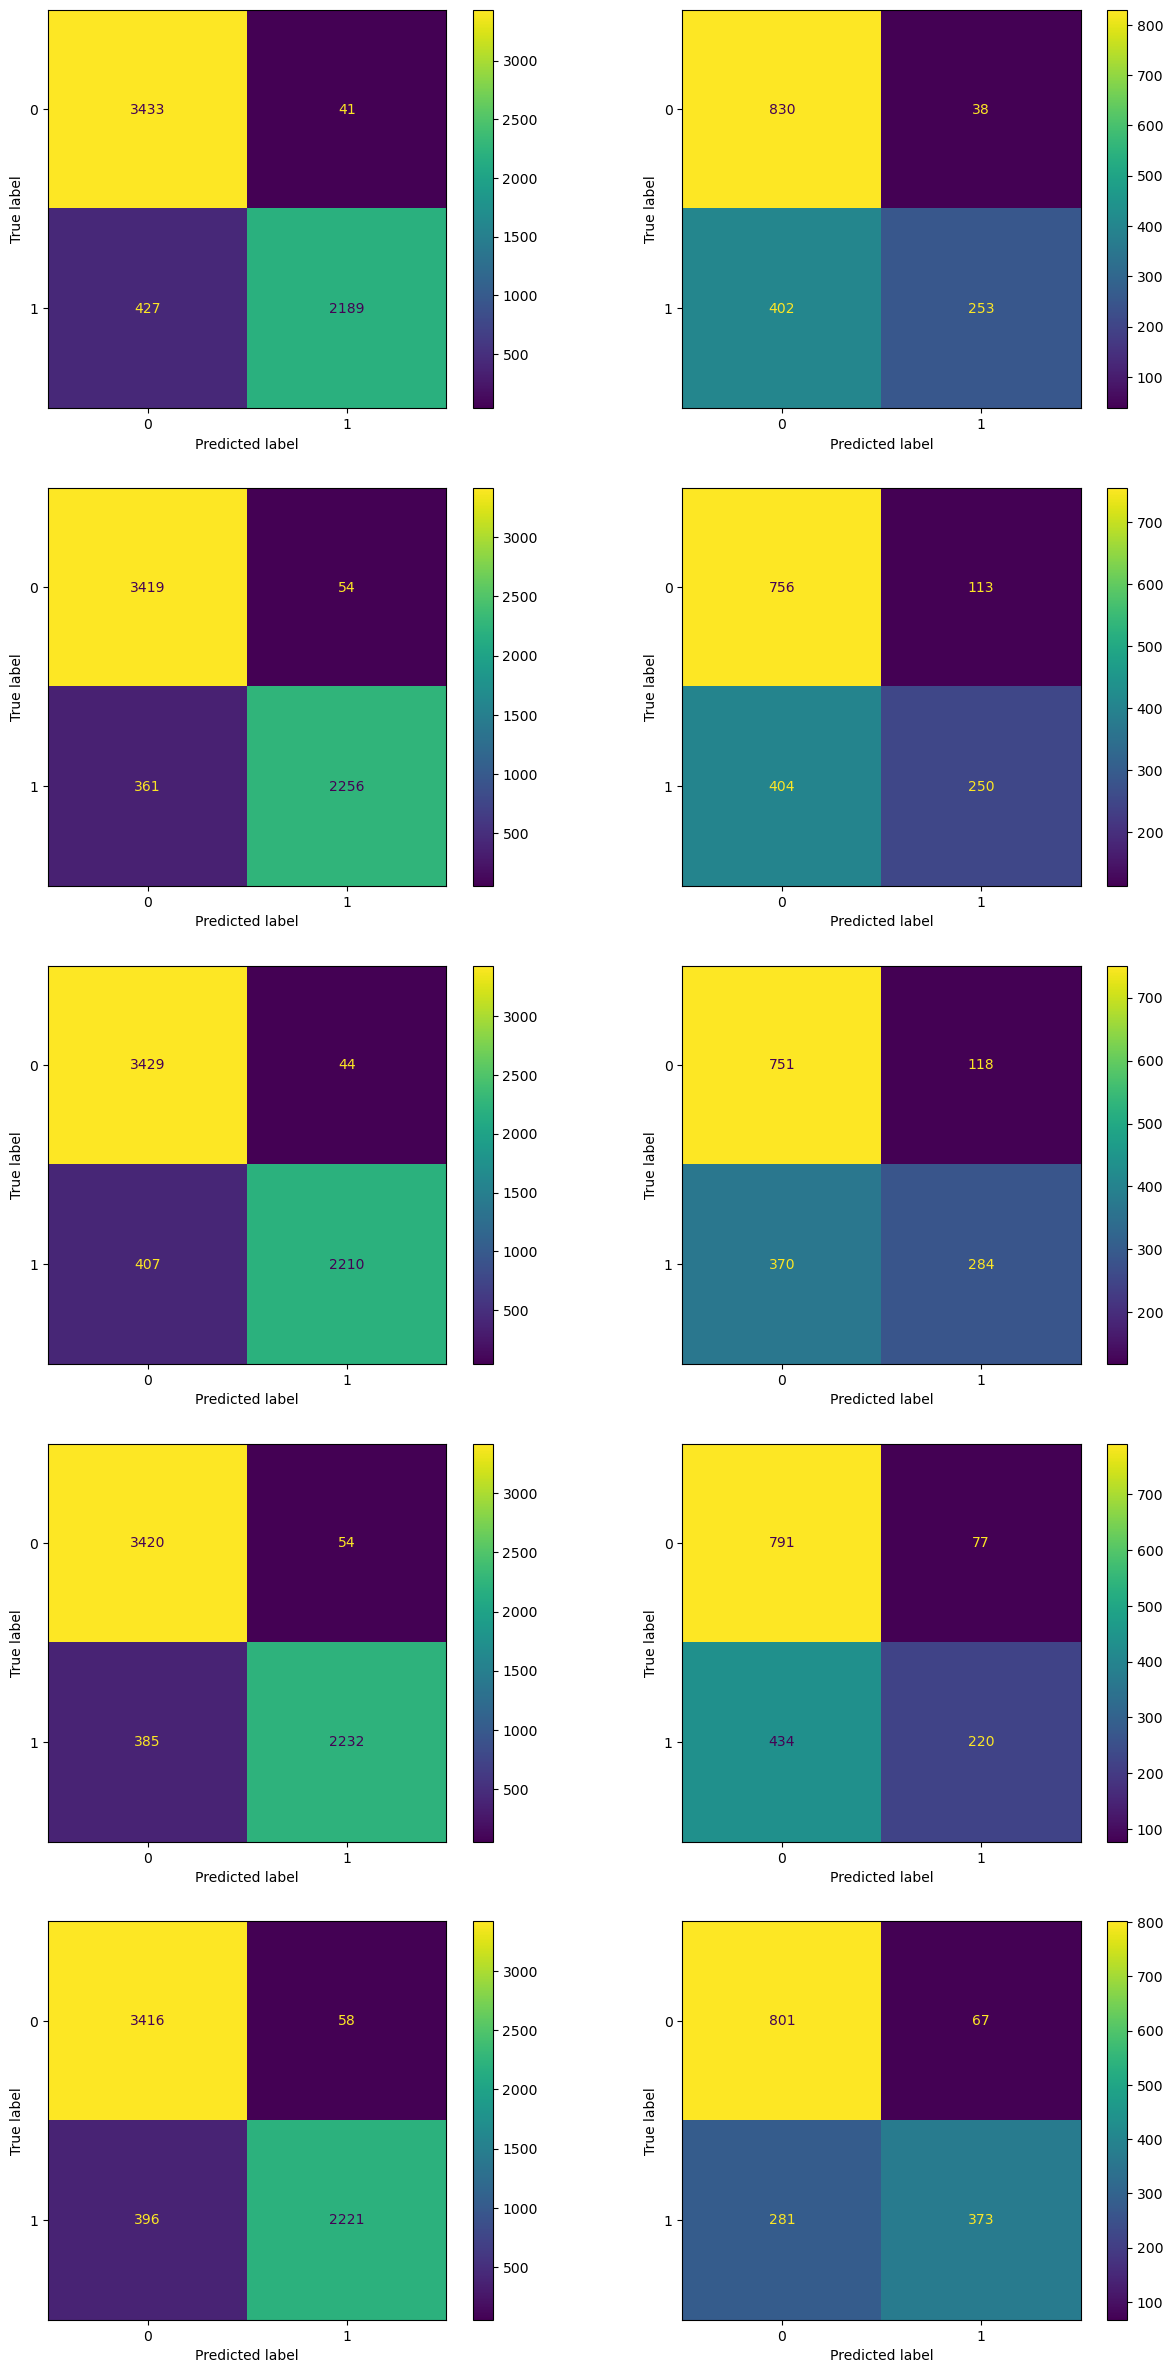

In [405]:
confusion_matrix_show(svc_metrices)

#### **2.3 Naive Bayes model**

In [274]:
from sklearn.naive_bayes import MultinomialNB
scaler = MinMaxScaler()
X_n_b = scaler.fit_transform(X)

In [275]:
cl_NB = MultinomialNB()
cl_NB_metrices = KFold_CrossValid(X_n_b, y, cl_NB, n_splits=5)

In [276]:
cl_NB_metrices

,train_acc_score,train_rec_score,train_prec_score,train_f1_score,train_con_matrix,test_acc_score,test_rec_score,test_prec_score,test_f1_score,test_con_matrix
n_split_1,0.903777,0.842890,0.926471,0.882706,<sklearn.metrics._plot.confusion_matrix.Confus...,0.692055,0.545038,0.676136,0.603550,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_2,0.906732,0.854413,0.922823,0.887302,<sklearn.metrics._plot.confusion_matrix.Confus...,0.645437,0.628440,0.580508,0.603524,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_3,0.906568,0.842186,0.933898,0.885674,<sklearn.metrics._plot.confusion_matrix.Confus...,0.689429,0.652905,0.634473,0.643557,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_4,0.908389,0.858617,0.922793,0.889549,<sklearn.metrics._plot.confusion_matrix.Confus...,0.715506,0.639144,0.679675,0.658786,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_5,0.905106,0.845243,0.927463,0.884446,<sklearn.metrics._plot.confusion_matrix.Confus...,0.752957,0.772171,0.689891,0.728716,<sklearn.metrics._plot.confusion_matrix.Confus...
average,0.906114,0.848670,0.926690,0.885935,NaN,0.699077,0.647540,0.652137,0.647627,NaN


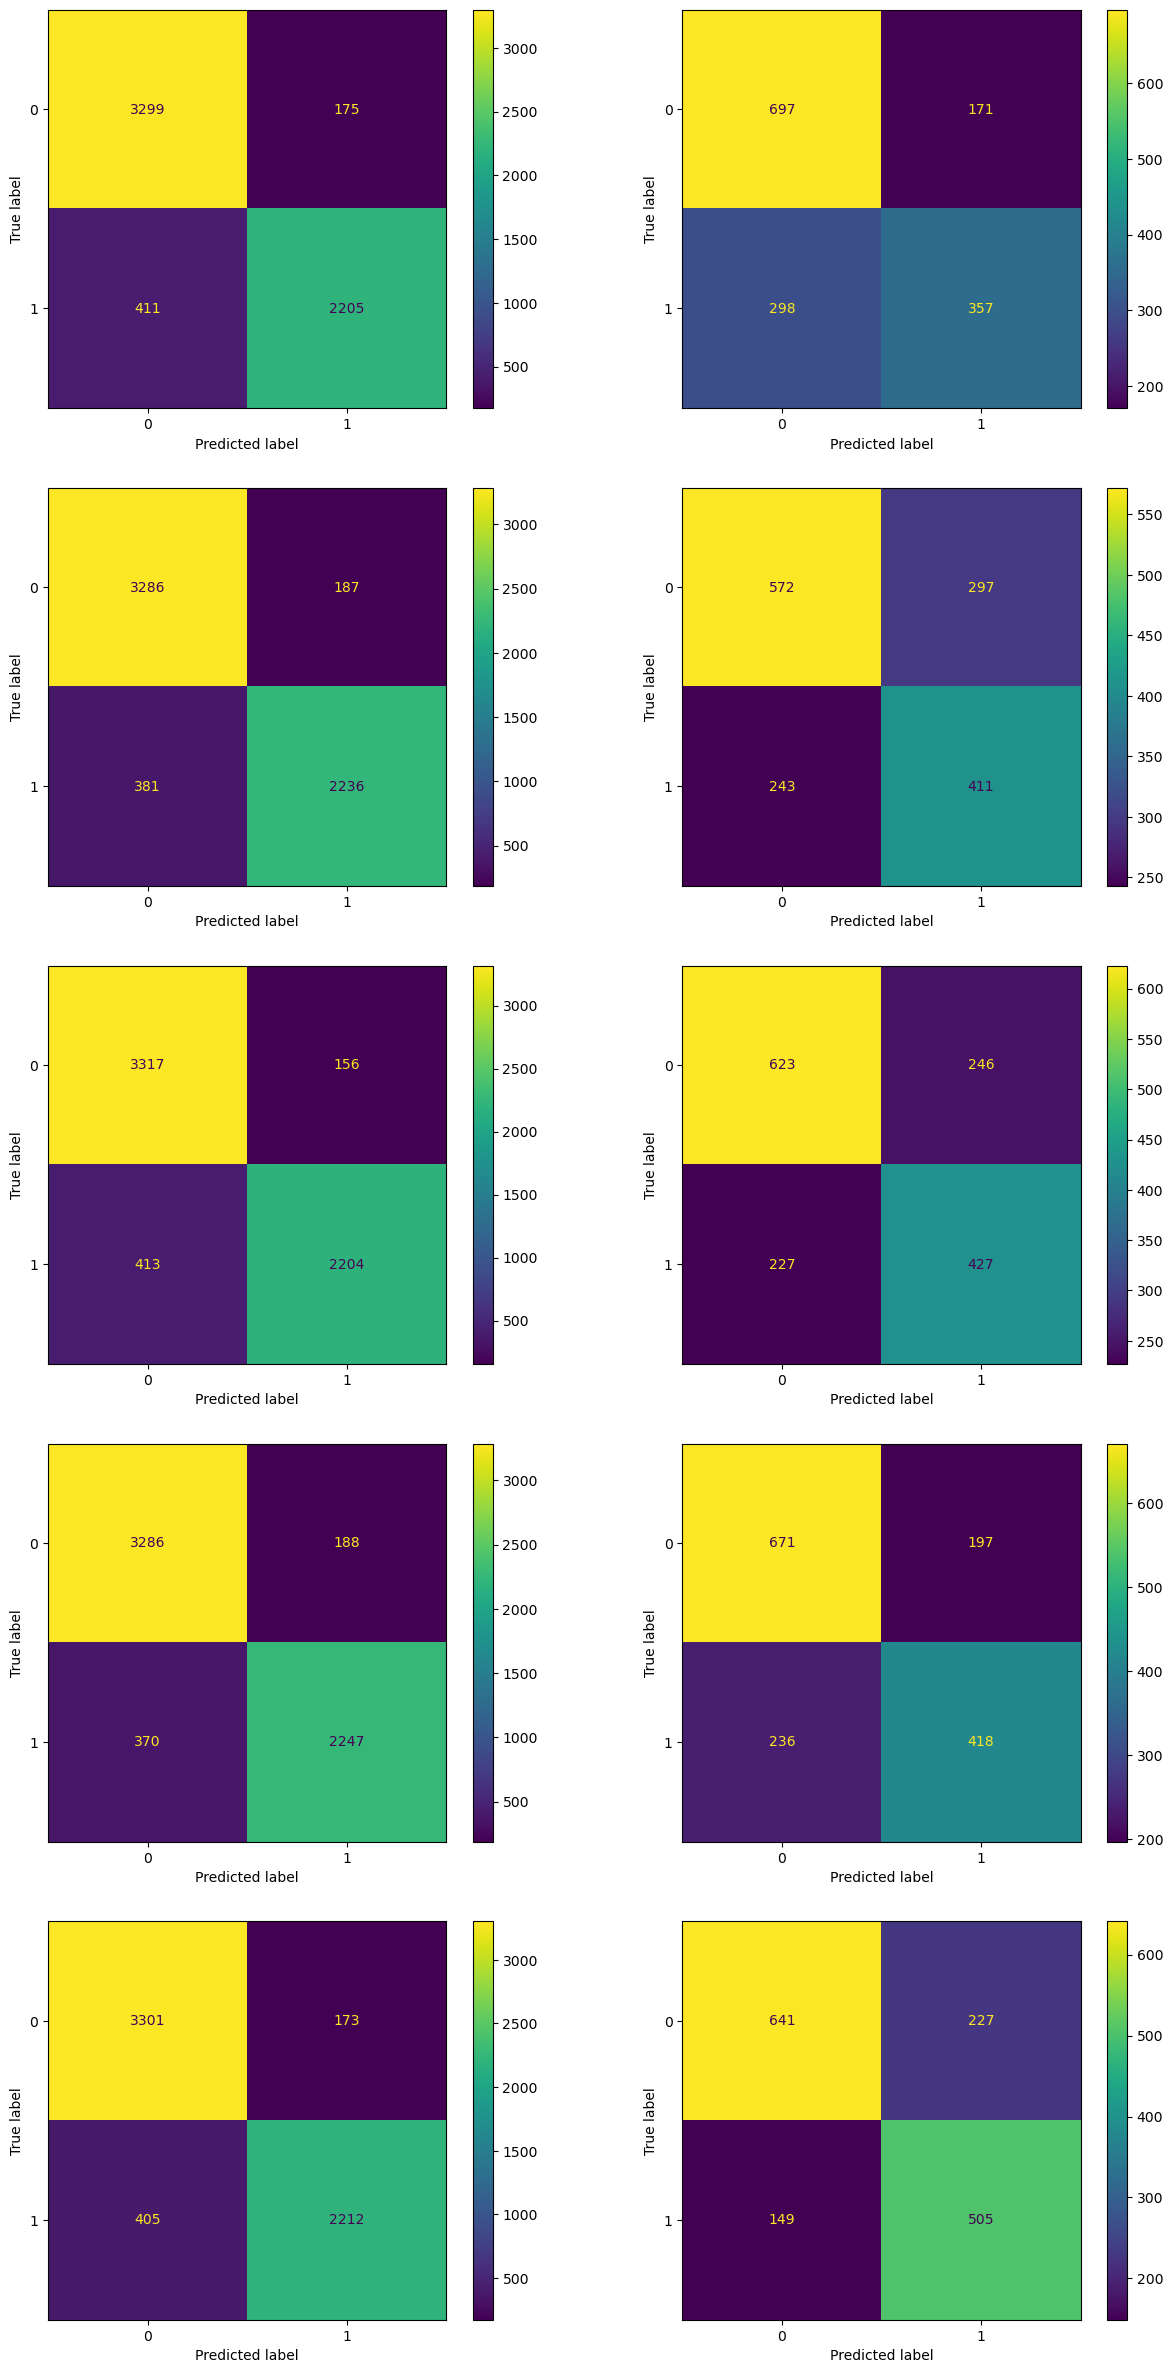

In [407]:
confusion_matrix_show(cl_NB_metrices)

#### **2.4 neural network model**

In [283]:
from sklearn.neural_network import MLPClassifier

In [284]:
MLPcl = MLPClassifier()

In [285]:
MLPcl_metrices = KFold_CrossValid(X, y, MLPcl, n_splits=5)

In [286]:
MLPcl_metrices

,train_acc_score,train_rec_score,train_prec_score,train_f1_score,train_con_matrix,test_acc_score,test_rec_score,test_prec_score,test_f1_score,test_con_matrix
n_split_1,0.983087,0.970566,0.989864,0.980120,<sklearn.metrics._plot.confusion_matrix.Confus...,0.648720,0.570992,0.595541,0.583009,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_2,0.983087,0.972870,0.987587,0.980173,<sklearn.metrics._plot.confusion_matrix.Confus...,0.592252,0.582569,0.522634,0.550976,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_3,0.985714,0.978219,0.988417,0.983292,<sklearn.metrics._plot.confusion_matrix.Confus...,0.615233,0.646789,0.543702,0.590782,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_4,0.984896,0.975545,0.989151,0.982301,<sklearn.metrics._plot.confusion_matrix.Confus...,0.645861,0.608563,0.584435,0.596255,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_5,0.982269,0.972870,0.985676,0.979231,<sklearn.metrics._plot.confusion_matrix.Confus...,0.645204,0.704893,0.570545,0.630643,<sklearn.metrics._plot.confusion_matrix.Confus...
average,0.983811,0.974014,0.988139,0.981023,NaN,0.629454,0.622761,0.563371,0.590333,NaN


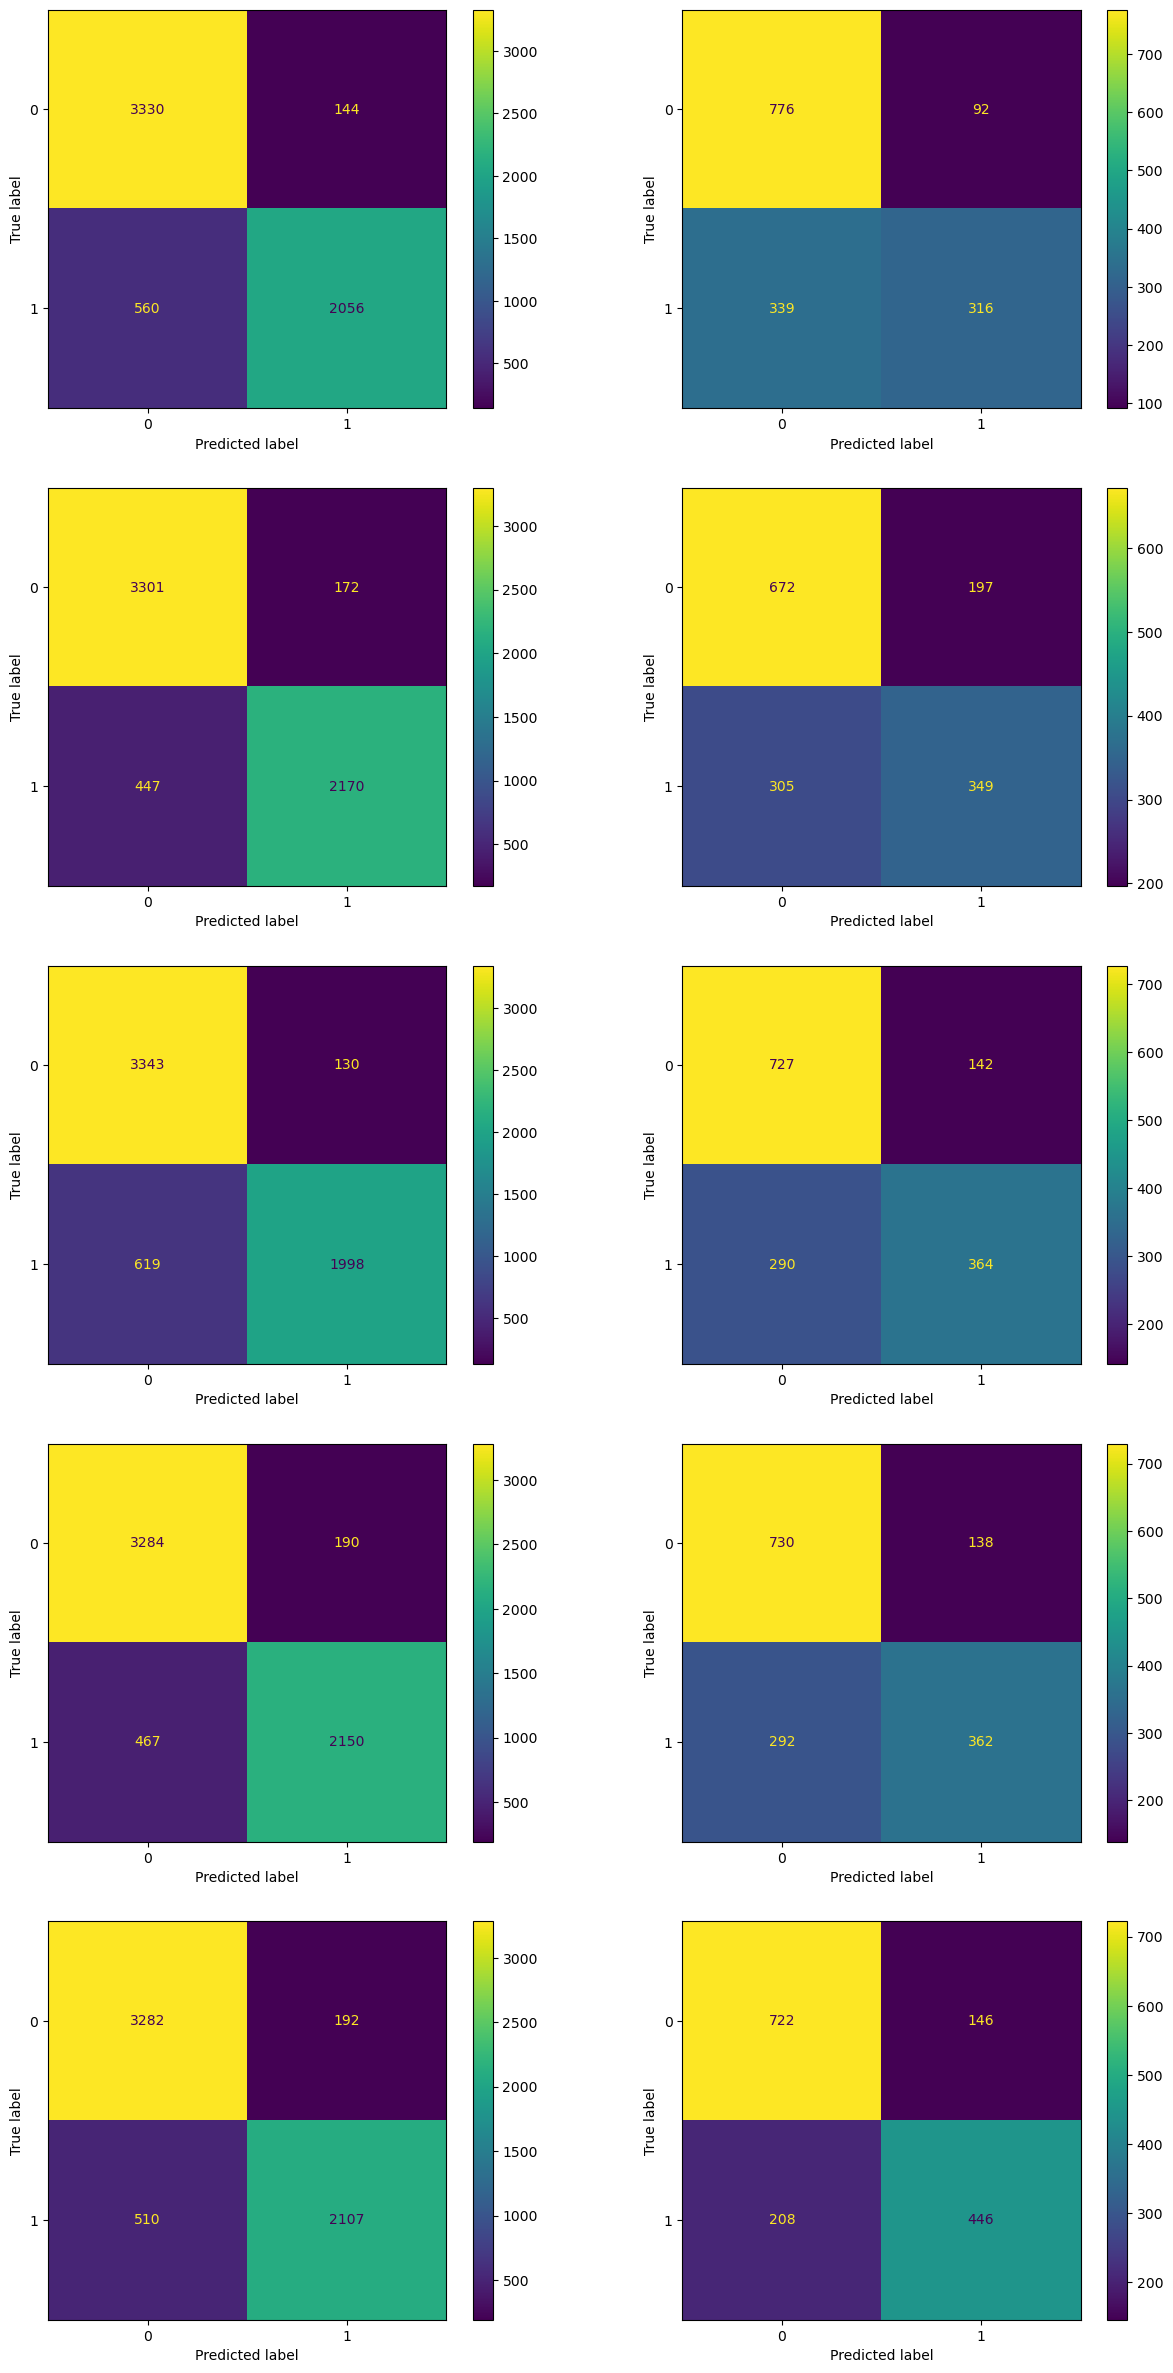

In [409]:
confusion_matrix_show(MLPcl_metrices)

#### **Conclusion and decision for the next step**

1. We need to choose one of the previous models for the grid search fine-tuning step.
2. Since we need to determine whether there is a disaster based on tweet texts, it’s crucial that the model minimizes false negatives.
3. Therefore, we should select the model with the highest recall metric.
4.	We will exclude both the Support Vector Machine and Logistic Regression models because they have the lowest recall accuracy, falling below 50%.
5.	The Naive Bayes and neural network models show similar performance in recall and other metrics, so we will consider both for the next step.

### **3. Cross_Validation using GridSearchCV to optimize model parameters and prevent overfitting.**

#### **3.1 Naive Bayes**

In [320]:
from sklearn.model_selection import GridSearchCV
GScl_NB = MultinomialNB()

In [322]:
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 50.0, 100.0], 
             'force_alpha' : [True, False],
               'fit_prior' : [True, False]}


GS_NB = GridSearchCV(GScl_NB, param_grid)

In [324]:
GS_NB.fit(X_n_b,y)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 50.0,
                                   100.0],
                         'fit_prior': [True, False],
                         'force_alpha': [True, False]})

In [354]:
GS_NB_results = pd.DataFrame(GS_NB.cv_results_)
GS_NB_results.sort_values(by='rank_test_score').head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_prior,param_force_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,0.325916,0.012347,0.008528,0.001110,10.0,True,False,"{'alpha': 10.0, 'fit_prior': True, 'force_alph...",0.682863,0.665135,0.707157,0.690539,0.783180,0.705775,0.040993,1
20,0.331679,0.024120,0.008852,0.000595,10.0,True,True,"{'alpha': 10.0, 'fit_prior': True, 'force_alph...",0.682863,0.665135,0.707157,0.690539,0.783180,0.705775,0.040993,1
17,0.326721,0.003860,0.008779,0.001050,1.0,True,False,"{'alpha': 1.0, 'fit_prior': True, 'force_alpha...",0.692055,0.645437,0.689429,0.715506,0.752957,0.699077,0.035193,3
16,0.383226,0.034773,0.010689,0.002699,1.0,True,True,"{'alpha': 1.0, 'fit_prior': True, 'force_alpha...",0.692055,0.645437,0.689429,0.715506,0.752957,0.699077,0.035193,3
27,0.363759,0.039876,0.029868,0.036726,50.0,False,False,"{'alpha': 50.0, 'fit_prior': False, 'force_alp...",0.678923,0.651346,0.692055,0.691853,0.760184,0.694872,0.035865,5


#### **3.2 neural network model**

In [663]:
param_grid = {'alpha' : [0.0001, 0.01, 1, 10],
              'early_stopping' : [True, False],
              'activation' : ['logistic', 'relu']}
MLP_cl = MLPClassifier(max_iter=1000)
MLPclGS = GridSearchCV(MLP_cl, param_grid, n_jobs=-1)
MLPclGS.fit(X, y)
MLPclGS_cv_results = pd.DataFrame(MLPclGS.cv_results_)

In [342]:
MLPclGS_cv_results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_early_stopping,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,19.905038,2.854783,0.080848,0.011473,relu,0.0001,True,"{'activation': 'relu', 'alpha': 0.0001, 'early...",0.709127,0.682863,0.709783,0.692510,0.769382,0.712733,0.030107,1
0,27.748713,2.815981,0.082374,0.009749,logistic,0.0001,True,"{'activation': 'logistic', 'alpha': 0.0001, 'e...",0.714380,0.675640,0.709127,0.706965,0.754271,0.712076,0.025092,2
10,22.720608,2.443250,0.063281,0.015561,relu,0.0100,True,"{'activation': 'relu', 'alpha': 0.01, 'early_s...",0.724228,0.643467,0.711753,0.708936,0.755585,0.708794,0.036617,3
13,57.949958,3.097307,0.050848,0.010799,relu,1.0000,False,"{'activation': 'relu', 'alpha': 1, 'early_stop...",0.717006,0.657912,0.688772,0.696452,0.775296,0.707088,0.039032,4
2,66.912930,16.366687,0.125738,0.045310,logistic,0.0100,True,"{'activation': 'logistic', 'alpha': 0.01, 'ear...",0.714380,0.657255,0.702561,0.695795,0.761498,0.706298,0.033591,5


**Conclusion**

In [370]:
print(f'The best parameters for Naive Bayes are : ', GS_NB_results[GS_NB_results['rank_test_score']==1]['params'].values)

The best parameters for Naive Bayes are :  [{'alpha': 10.0, 'fit_prior': True, 'force_alpha': True}
 {'alpha': 10.0, 'fit_prior': True, 'force_alpha': False}]


The best parameters for Naive Bayes are :  [{'alpha': 10.0, 'fit_prior': True, 'force_alpha': True}
 {'alpha': 10.0, 'fit_prior': True, 'force_alpha': False}]

In [372]:
print(f'The best parameters for neural network are : ', MLPclGS_cv_results[MLPclGS_cv_results['rank_test_score']==1]['params'].values)

The best parameters for neural network are :  ["{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True}"]


The best parameters for neural network are :  ["{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True}"]

### **4. Run the chosen parameters on the selcted models.**

**First: Naive Bayes model**

In [382]:
cl_NB_1 = MultinomialNB(alpha=10.0, fit_prior=True, force_alpha=True)
cl_NB_metrices_1 = KFold_CrossValid(X_n_b, y, cl_NB_1, n_splits=5)

In [383]:
cl_NB_metrices_1

,train_acc_score,train_rec_score,train_prec_score,train_f1_score,train_con_matrix,test_acc_score,test_rec_score,test_prec_score,test_f1_score,test_con_matrix
n_split_1,0.841379,0.683869,0.927905,0.787412,<sklearn.metrics._plot.confusion_matrix.Confus...,0.682863,0.374046,0.770440,0.503597,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_2,0.851560,0.712266,0.925062,0.804836,<sklearn.metrics._plot.confusion_matrix.Confus...,0.665135,0.467890,0.653846,0.545455,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_3,0.849097,0.693924,0.938987,0.798066,<sklearn.metrics._plot.confusion_matrix.Confus...,0.707157,0.498471,0.734234,0.593807,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_4,0.848465,0.705770,0.923500,0.800087,<sklearn.metrics._plot.confusion_matrix.Confus...,0.690539,0.418960,0.750685,0.537782,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_5,0.839599,0.676347,0.931579,0.783706,<sklearn.metrics._plot.confusion_matrix.Confus...,0.783180,0.620795,0.831967,0.711033,<sklearn.metrics._plot.confusion_matrix.Confus...
average,0.846020,0.694435,0.929406,0.794821,NaN,0.705775,0.476032,0.748235,0.578335,NaN


In [386]:
cl_NB_2 = MultinomialNB(alpha=10, fit_prior=True, force_alpha=False)
cl_NB_metrices_2 = KFold_CrossValid(X_n_b, y, cl_NB_2, n_splits=5)

In [387]:
cl_NB_metrices_2

,train_acc_score,train_rec_score,train_prec_score,train_f1_score,train_con_matrix,test_acc_score,test_rec_score,test_prec_score,test_f1_score,test_con_matrix
n_split_1,0.841379,0.683869,0.927905,0.787412,<sklearn.metrics._plot.confusion_matrix.Confus...,0.682863,0.374046,0.770440,0.503597,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_2,0.851560,0.712266,0.925062,0.804836,<sklearn.metrics._plot.confusion_matrix.Confus...,0.665135,0.467890,0.653846,0.545455,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_3,0.849097,0.693924,0.938987,0.798066,<sklearn.metrics._plot.confusion_matrix.Confus...,0.707157,0.498471,0.734234,0.593807,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_4,0.848465,0.705770,0.923500,0.800087,<sklearn.metrics._plot.confusion_matrix.Confus...,0.690539,0.418960,0.750685,0.537782,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_5,0.839599,0.676347,0.931579,0.783706,<sklearn.metrics._plot.confusion_matrix.Confus...,0.783180,0.620795,0.831967,0.711033,<sklearn.metrics._plot.confusion_matrix.Confus...
average,0.846020,0.694435,0.929406,0.794821,NaN,0.705775,0.476032,0.748235,0.578335,NaN


**Second: neural network model**

In [393]:
MLPcl = MLPClassifier(activation = 'relu', alpha = 0.0001, early_stopping = True)
MLPcl_metrices = KFold_CrossValid(X, y, MLPcl, n_splits=5)
MLPcl_metrices

,train_acc_score,train_rec_score,train_prec_score,train_f1_score,train_con_matrix,test_acc_score,test_rec_score,test_prec_score,test_f1_score,test_con_matrix
n_split_1,0.884401,0.785933,0.934545,0.853821,<sklearn.metrics._plot.confusion_matrix.Confus...,0.717006,0.482443,0.774510,0.594544,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_2,0.898358,0.829194,0.926558,0.875176,<sklearn.metrics._plot.confusion_matrix.Confus...,0.670387,0.533639,0.639194,0.581667,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_3,0.877011,0.763470,0.938910,0.842150,<sklearn.metrics._plot.confusion_matrix.Confus...,0.716349,0.556575,0.719368,0.627586,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_4,0.892136,0.821551,0.918803,0.867460,<sklearn.metrics._plot.confusion_matrix.Confus...,0.717477,0.553517,0.724000,0.627383,<sklearn.metrics._plot.confusion_matrix.Confus...
n_split_5,0.884748,0.805120,0.916485,0.857201,<sklearn.metrics._plot.confusion_matrix.Confus...,0.767411,0.681957,0.753378,0.715891,<sklearn.metrics._plot.confusion_matrix.Confus...
average,0.887331,0.801054,0.927061,0.859162,NaN,0.717726,0.561626,0.722090,0.629414,NaN


# <center>**5. Interpretation and Application**</center>

- **After performing cross-validation and grid search for parameter tuning, we found that the best estimator based on recall, precision, accuracy, and F1 score is the neural network model. To further improve the results, I recommend using a more complex neural network if a powerful GPU is available.**
- **Given that the model’s predictions could be utilized in disaster response and emergency management, it’s important to note that with the current best recall, the model can accurately predict two out of three tweets. This indicates that while the model performs well, there is still room for improvement to ensure more reliable predictions in critical situations.**